# Creating a Kaggle/Data Science Workflow

This notebook serves as a template for Kaggle competition submission workflow.

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

train = pd.read_csv('train.csv')
holdout = pd.read_csv('test.csv')

holdout.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


### Preprocessing the Data

In [2]:
# %load functions.py
def process_missing(df):
    """Handle various missing values from the data set

    Usage
    ------

    holdout = process_missing(holdout)
    """
    df["Fare"] = df["Fare"].fillna(train["Fare"].mean())
    df["Embarked"] = df["Embarked"].fillna("S")
    return df

def process_age(df):
    """Process the Age column into pre-defined 'bins' 

    Usage
    ------

    train = process_age(train)
    """
    df["Age"] = df["Age"].fillna(-0.5)
    cut_points = [-1,0,5,12,18,35,60,100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

def process_fare(df):
    """Process the Fare column into pre-defined 'bins' 

    Usage
    ------

    train = process_fare(train)
    """
    cut_points = [-1,12,50,100,1000]
    label_names = ["0-12","12-50","50-100","100+"]
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    return df

def process_cabin(df):
    """Process the Cabin column into pre-defined 'bins' 

    Usage
    ------

    train process_cabin(train)
    """
    df["Cabin_type"] = df["Cabin"].str[0]
    df["Cabin_type"] = df["Cabin_type"].fillna("Unknown")
    df = df.drop('Cabin',axis=1)
    return df

def process_titles(df):
    """Extract and categorize the title from the name column 

    Usage
    ------

    train = process_titles(train)
    """
    titles = {
        "Mr" :         "Mr",
        "Mme":         "Mrs",
        "Ms":          "Mrs",
        "Mrs" :        "Mrs",
        "Master" :     "Master",
        "Mlle":        "Miss",
        "Miss" :       "Miss",
        "Capt":        "Officer",
        "Col":         "Officer",
        "Major":       "Officer",
        "Dr":          "Officer",
        "Rev":         "Officer",
        "Jonkheer":    "Royalty",
        "Don":         "Royalty",
        "Sir" :        "Royalty",
        "Countess":    "Royalty",
        "Dona":        "Royalty",
        "Lady" :       "Royalty"
    }
    extracted_titles = df["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
    df["Title"] = extracted_titles.map(titles)
    return df

def create_dummies(df,column_name):
    """Create Dummy Columns (One Hot Encoding) from a single Column

    Usage
    ------

    train = create_dummies(train,"Age")
    """
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

In [3]:
def preprocess(df):
    df = process_missing(df)
    df = process_age(df)
    df = process_fare(df)
    df = process_titles(df)
    df = process_cabin(df)
    
    dummy_vars = ['Age_categories', 'Fare_categories', 'Title', 'Cabin_type', 'Sex']
    for dummy in dummy_vars:
        df = create_dummies(df, dummy)
        
    return df

### Exploring the Data

In [4]:
train = preprocess(train)
holdout = preprocess(holdout)

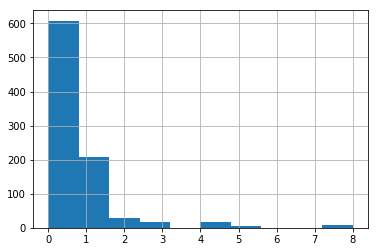

In [5]:
train['SibSp'].value_counts()
train['SibSp'].hist()
plt.show()

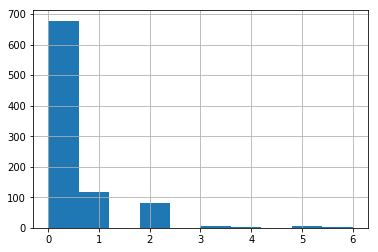

In [6]:
train['Parch'].hist()
plt.show()

In [7]:
sub_table_family = train[['Parch', 'SibSp', 'Survived']]
sub_table_family.head()

,Parch,SibSp,Survived
0,0,1,0
1,0,1,1
2,0,0,1
3,0,1,1
4,0,0,0


In [8]:
sub_table_family.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 3 columns):
Parch       891 non-null int64
SibSp       891 non-null int64
Survived    891 non-null int64
dtypes: int64(3)
memory usage: 21.0 KB


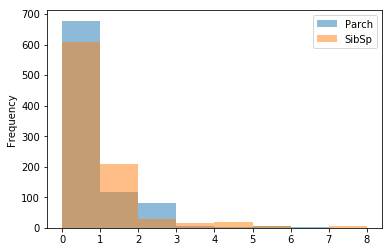

In [9]:
sub_table_family.drop('Survived', axis =1).plot.hist(alpha = 0.5, bins = 8)

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


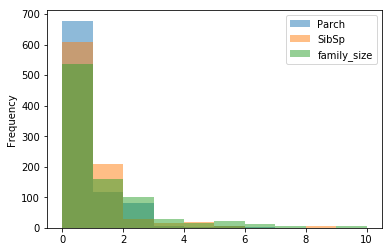

In [10]:
sub_table_family['family_size'] = sub_table_family['SibSp'] + sub_table_family['Parch']
sub_table_family.drop('Survived', axis = 1).plot.hist(alpha = 0.5, bins = 10)
plt.show()

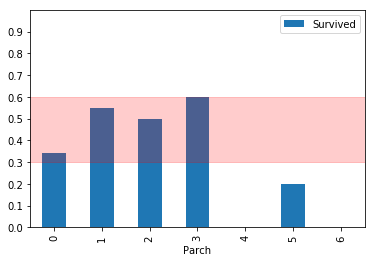

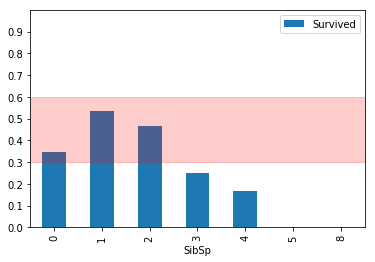

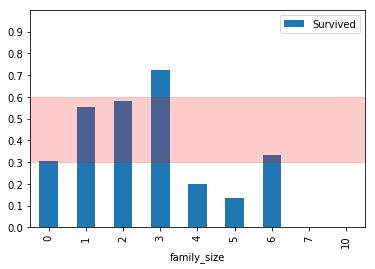

In [11]:
for col in sub_table_family.columns.drop("Survived"):
    pivot = sub_table_family.pivot_table(index=col,values="Survived")
    pivot.plot.bar(ylim=(0,1),yticks=np.arange(0,1,.1))
    plt.axhspan(.3, .6, alpha=0.2, color='red')
    plt.show()

The SibSp column shows the number of siblings and/or spouses each passenger had on board, while the Parch columns shows the number of parents or children each passenger had onboard. Neither column has any missing values.

Looking at these collections of graphs, passengers that had at least one family member on board were more likely to survive than if they were travelling alone.


### Engineering New Features

In [12]:
def family_members(df):
    new_df = df.copy()
    new_df['family_size'] = new_df['Parch'] + new_df['SibSp']
    isalone = []
    for index, row in new_df.iterrows():
        if row['family_size'] > 0:
            isalone.append(0)
        else:
            isalone.append(1)
            
    new_df['isalone'] = isalone
    return new_df

train = family_members(train)
holdout = family_members(holdout)

### Selecting Best-Performing Features

In [13]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier

def select_features(df):
    num_df = df.select_dtypes(['int64', 'float64'])
    all_X = num_df.drop(['PassengerId','Survived'], axis = 1)
    all_y = num_df['Survived']
    rf = RandomForestClassifier(random_state = 1)
    selector = RFECV(rf, cv = 10)
    selector.fit(all_X, all_y)
    print(all_X.columns[selector.support_])
    optimal_cols = all_X.columns[selector.support_]
    return optimal_cols

optimized_columns = select_features(train)

Index(['Pclass', 'Age', 'Parch', 'Fare', 'family_size'], dtype='object')


### Selecting and Tuning Different Algorithms

In [14]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

def select_model(df, features):
    df_copy = df.copy()
    all_X = df_copy[features]
    all_y = df_copy['Survived']
    
    models_list = [
        {'name': 'LogisticRegression',
         'estimator':LogisticRegression(),
        'hyperparameters':{
         'solver':['newton-cg', 'lbfgs', 'liblinear']   
        }},
        
        {'name':'KNeighborsClassifier',
         'estimator': KNeighborsClassifier(),
         'hyperparameters':{
            'n_neighbors':range(1,20,2),
            'weights':['distance', 'uniform'],
            'algorithm':['ball_tree', 'kd_tree', 'brute'],
            'p':[1,2]   
         }},
        
        
        {'name':'RandomForestClassifier',
        'estimator':RandomForestClassifier(),
        'hyperparameters':{
            'n_estimators':[4,6,9],
            'criterion':['entropy', 'gini'],
            'max_depth':[2,5,10],
            'max_features':['log2', 'sqrt'],
            'min_samples_leaf':[1,5,8],
            'min_samples_split':[2,3,5]
        }}
    ]
    
    for model in models_list:
        print(model['name'])
        grid = GridSearchCV(model['estimator'], param_grid = model['hyperparameters'], cv = 10)
        grid.fit(all_X, all_y)
        model['best_params'] = grid.best_params_
        model['best_score'] = grid.best_score_
        model['best_estimator'] = grid.best_estimator_
        print(grid.best_params_, grid.best_score_)
        
    return models_list

models_list = select_model(train, optimized_columns)        

LogisticRegression
{'solver': 'liblinear'} 0.7014590347923682
KNeighborsClassifier
{'algorithm': 'ball_tree', 'n_neighbors': 19, 'p': 1, 'weights': 'uniform'} 0.7003367003367004
RandomForestClassifier
{'criterion': 'entropy', 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 9} 0.7373737373737373


### Making a Submission to Kaggle

In [16]:
def save_submission_file(model, features, filename = 'submission.csv'):
    predictions = model.predict(holdout[features])
    submission = pd.DataFrame({
        'PassengerID':holdout['PassengerId'],
        'Survived':predictions
    })
    submission.to_csv(filename, index=False)
    
best_score = 0
best_model = ''
for model in models_list:
    if model['best_score'] > best_score:
        best_score = model['best_score']
        best_model = model['best_estimator']
    
save_submission_file(best_model, optimized_columns, 'submission.csv')